# Esercitazione 3 
Esercizio di windowing. Caricare in input il segnale test e poi LCD93S1 fare windowing con:
- segmentattizzazione segnale
- spettro del segnale finestrato
- finestramento del segnale con una funzione di smooth
- log-spectrum del segnale campionato

Per prima cosa, andiamo a caricare il campione audio

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy 
import scipy.io
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np

/home/gabriele/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Sample rate:  16000
Data:  (69985,)
numero di campioni = 69985
length (durata)= 4.3740625 s


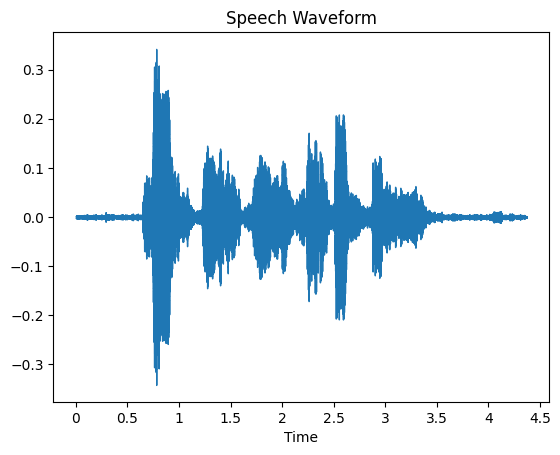

In [2]:
import librosa
import matplotlib.pyplot as plt

filename = "test.wav"
signal, sample_rate = librosa.load(filename, sr=16000)

print("Sample rate: ", sample_rate)
print("Data: ", signal.shape)
print(f"numero di campioni = {signal.shape[0]}")
# print(f"frequenza di campionamento: {samplerate}")
length = signal.shape[0] / sample_rate
print(f"length (durata)= {length} s")

# Plot the waveform
plt.figure()
librosa.display.waveshow(signal, sr=sample_rate)
plt.title("Speech Waveform")
plt.show()

In [17]:
def segment_signal(signal, fs, t_window_ms = 0.03):
    '''
    Frequenza in kHz, finestra in ms
    '''
    n_samples_window = int(fs * t_window_ms)
    print(f"Numero di campioni per finestra: {n_samples_window}")
    num_segmenti = int(signal.shape[0] // n_samples_window)
    n = np.linspace(0.5, n_samples_window-0.5, n_samples_window)
    print(f"Numero di segmenti: {num_segmenti}")
    print(f"Numero di campionamento: {len(n)}")
    # Lista per conservare i segmenti finestrati
    segmenti = []
    # Crea i segmenti
    for i in range(num_segmenti):
        inizio = i * n_samples_window
        fine = (i + 1) * n_samples_window
        segmento = signal[inizio:fine]
        # normalizzazione
        segmento = segmento / np.max(np.abs(segmento))
        segmenti.append(segmento)
    # Gestisci eventuali campioni rimanenti
    if len(signal) % n_samples_window != 0:
        segmento_parziale = signal[num_segmenti * n_samples_window:]
        segmenti.append(segmento_parziale)
    # segmenti = segmenti / np.max(np.abs(segmenti)) # normalizzazione
    return segmenti

segmenti = segment_signal(signal, fs=sample_rate) 

Numero di campioni per finestra: 480
Numero di segmenti: 145
Numero di campionamento: 480


In [21]:
# # se volessi ricostruire il segnale finestrato
# # Identifica i segmenti tra il secondo 1 e il secondo 2
# start_time = 1  # secondo 1
# end_time = 2    # secondo 2
# t_window = 0.03

# # Calcola gli indici dei segmenti
# start_index = int(start_time * sample_rate // (sample_rate * t_window))
# end_index = int(end_time * sample_rate // (sample_rate * t_window))

# # Concatenare i segmenti tra il secondo 1 e il secondo 2
# segmento_ricomposto = np.concatenate(segmenti[start_index:end_index])

# # Crea il grafico del segnale ricomposto
# plt.figure(figsize=(10, 4))
# plt.plot(np.arange(len(segmento_ricomposto)) / sample_rate, segmento_ricomposto)
# plt.title("Segnale Ricomposto dal secondo 1 al secondo 2")
# plt.xlabel("Tempo (s)")
# plt.ylabel("Ampiezza")
# plt.grid(True)
# plt.show()

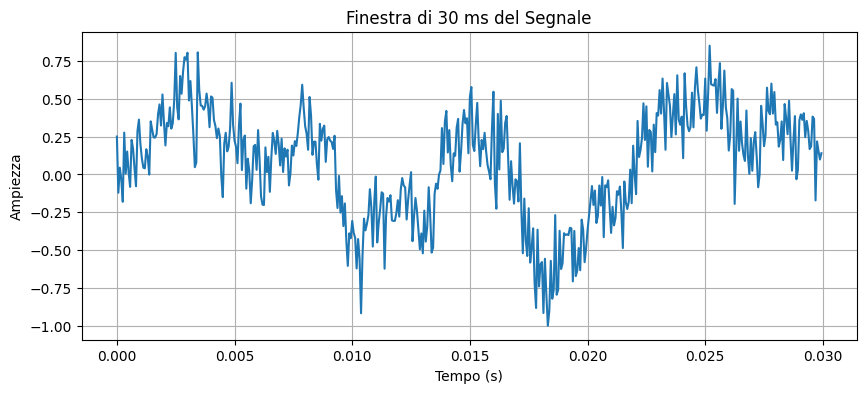

In [18]:
# Crea il grafico
segmento = segmenti[2]
t_window = 30
plt.figure(figsize=(10, 4))
plt.plot(np.arange(len(segmento)) / sample_rate, segmento)
plt.title(f"Finestra di {t_window} ms del Segnale")
plt.xlabel("Tempo (s)")
plt.ylabel("Ampiezza")
plt.grid(True)
plt.show()

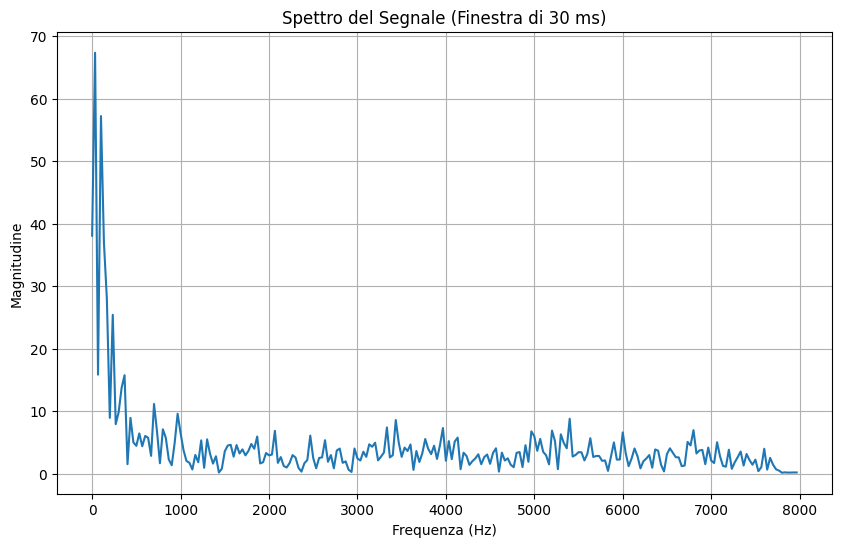

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Funzione per calcolare lo spettro di una finestra
def calcola_spettro_finestra(segnale, fs):
    # Applicare la Trasformata di Fourier al segnale
    spetto = np.fft.fft(segnale)
    # Calcolare la frequenza associata a ciascun punto dello spettro
    n = len(segnale)
    frequenze = np.fft.fftfreq(n, 1/fs)
    # Prendi solo la parte positiva dello spettro (simmetrico)
    spetto = np.abs(spetto[:n//2])  # Magnitudine del segnale
    frequenze = frequenze[:n//2]  # Frequenze positive
    return frequenze, spetto

# Calcolare lo spettro della finestra
frequenze, spettro = calcola_spettro_finestra(segmento, sample_rate)

# Plot dello spettro
plt.figure(figsize=(10, 6))
plt.plot(frequenze, spettro)
plt.title("Spettro del Segnale (Finestra di 30 ms)")
plt.xlabel("Frequenza (Hz)")
plt.ylabel("Magnitudine")
plt.grid(True)
plt.show()


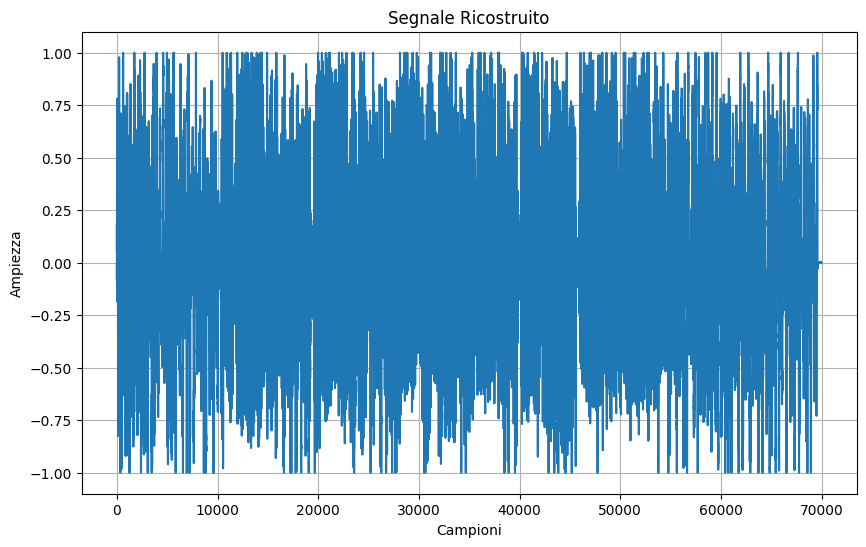

In [20]:
def ricostruzione_segnale(segmenti):
    segnale_ricostruito = np.concatenate(segmenti)
    # Plot del segnale ricostruito
    plt.figure(figsize=(10, 6))
    plt.plot(segnale_ricostruito)
    plt.title("Segnale Ricostruito")
    plt.xlabel("Campioni")
    plt.ylabel("Ampiezza")
    plt.grid(True)
    plt.show()
    
ricostruzione_segnale(segmenti)

Come possiamo notare, il segmento in se per se non ci da tanta informazione, questo perché intervengono molti fattori nella riproduzione del segnale del parlato, tra cui:
- aliasing
- interruzione vocale
- respiro

Quindi è utile applicare funzioni di windowing come:
- funzione rettangolare
- funzione di Hanning
- funzione di Hamming

In [21]:
def windowing_f(segmento, f_window):
    return segmento*f_window

In [22]:
# Funzione per calcolare lo spettro di una finestra
from numpy import log10


def calcola_spettro_finestra(segnale, fs):
    # Applicare la Trasformata di Fourier al segnale
    spetto = np.fft.fft(segnale)
    # Calcolare la frequenza associata a ciascun punto dello spettro
    n = len(segnale)
    frequenze = np.fft.fftfreq(n, 1/fs)
    # Prendi solo la parte positiva dello spettro (simmetrico)
    spetto = np.abs(spetto[:n//2])  # Magnitudine del segnale
    frequenze = frequenze[:n//2]  # Frequenze positive
    return frequenze, spetto

def spettro_f(segmento, sample_rate=sample_rate):
    # Crea il grafico
    t_window = 30
    plt.figure(figsize=(10, 4))
    plt.plot(np.arange(len(segmento)) / sample_rate, segmento)
    plt.title(f"Finestra di {t_window} ms del Segnale")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Ampiezza")
    plt.grid(True)
    plt.show()
    # Calcolare lo spettro della finestra
    frequenze, spettro = calcola_spettro_finestra(segmento, sample_rate)
    # Plot dello spettro
    plt.figure(figsize=(10, 6))
    plt.plot(frequenze, 20*log10(spettro))
    plt.title("Spettro del Segnale (Finestra di 30 ms)")
    plt.xlabel("Frequenza (Hz)")
    plt.ylabel("Log Magnitude")
    plt.grid(True)
    plt.show()


In [27]:
from scipy import signal

rect = signal.windows.boxcar(len(segmenti[0])) # finestra della dimensione di un segmento
hamm = signal.windows.hamming(len(segmenti[0]))
hann = signal.windows.hann(len(segmenti[0]))

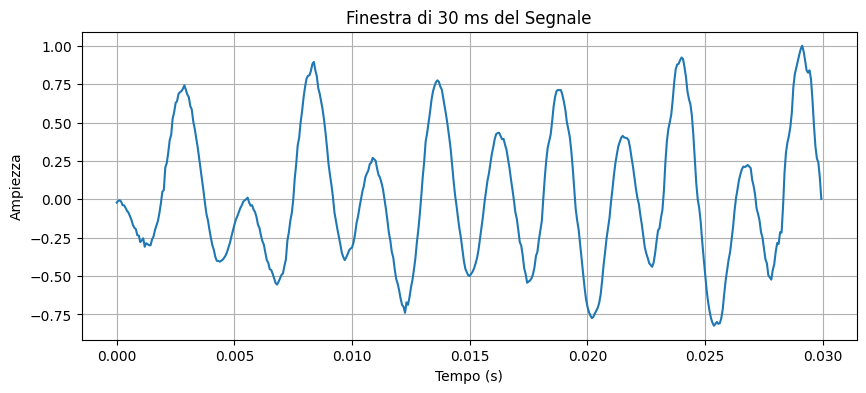

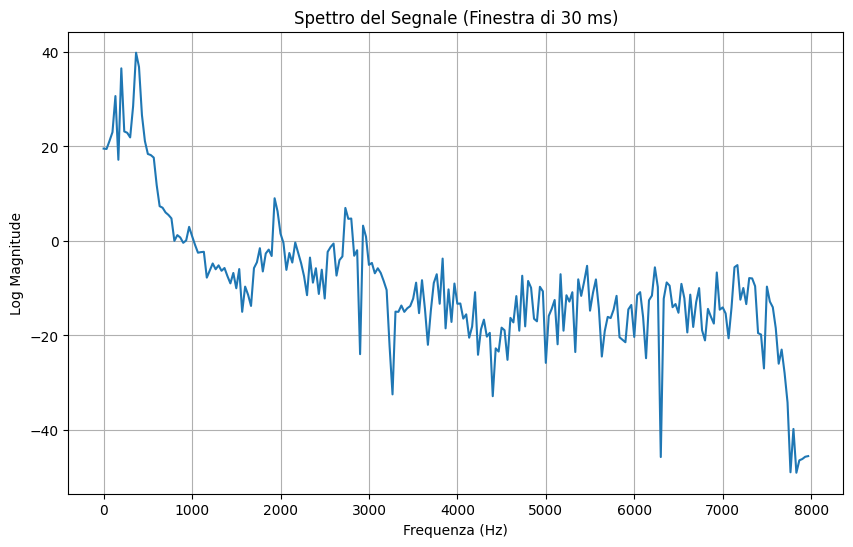

In [24]:
# provo prima la rect
signal_rect = windowing_f(segmenti[25], rect)
spettro_f(signal_rect)

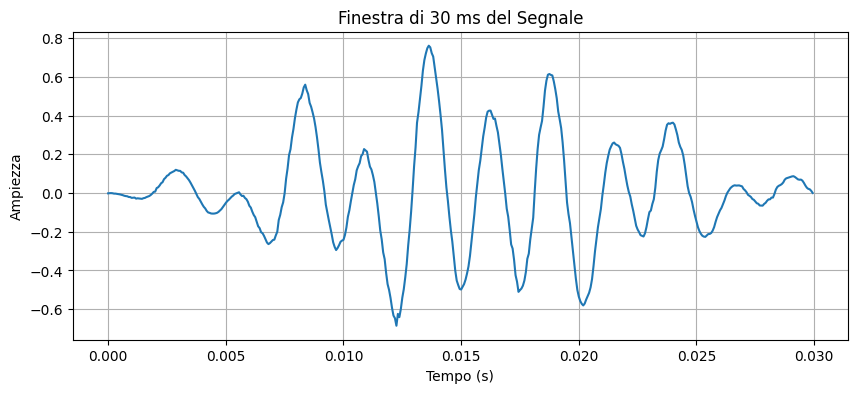

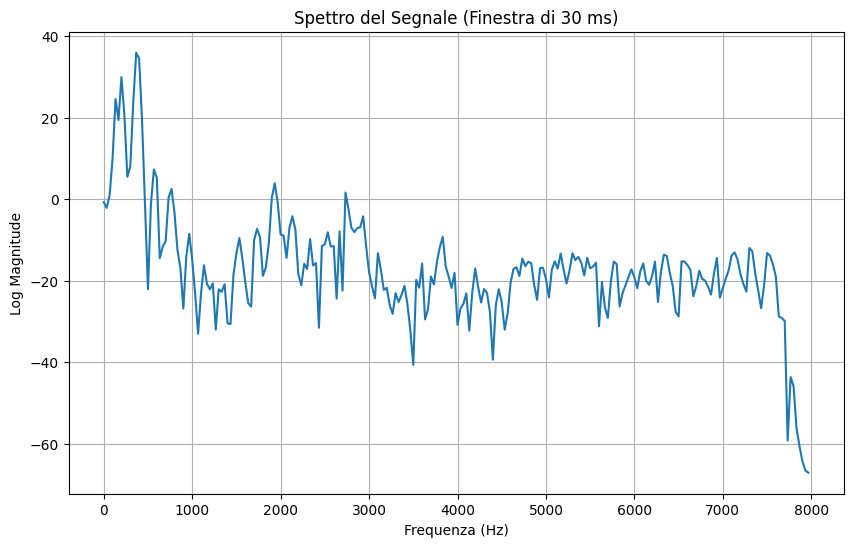

In [25]:
# provo prima la rect
signal_rect = windowing_f(segmenti[25], hamm)
spettro_f(signal_rect)

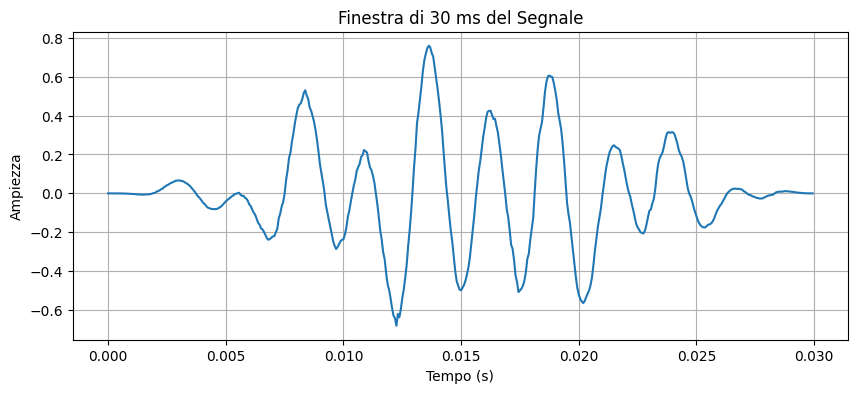

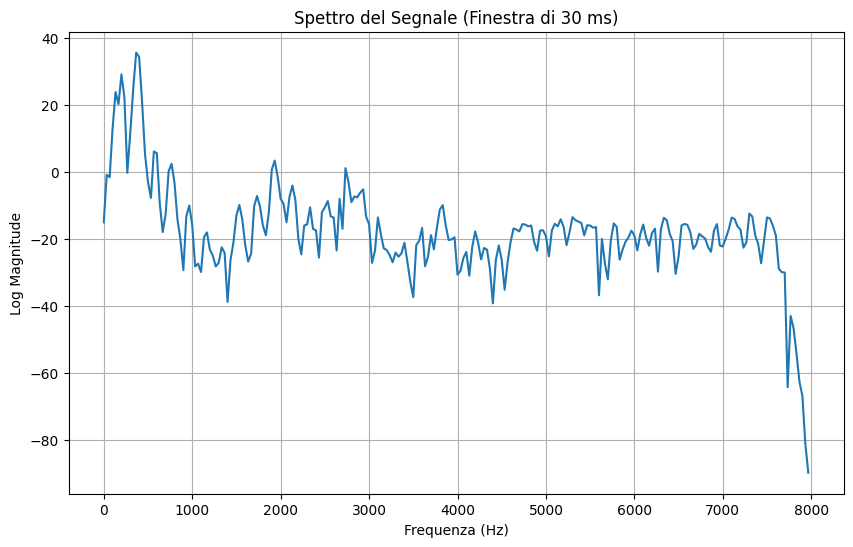

In [26]:
# provo prima la rect
signal_rect = windowing_f(segmenti[25], hann)
spettro_f(signal_rect)

In [34]:
print(len(segmenti))
print(len(segmenti[0]))
datax = []
for i in range(len(segmenti)-1):
    segmento_win = windowing_f(segmento=segmenti[i], f_window=hann)
    datax.append(segmento_win)

146
480


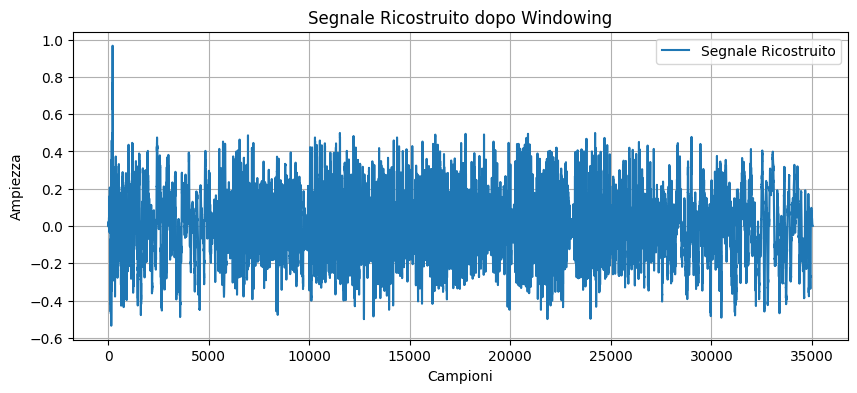

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def ricostruisci_segnale(segmenti_finestrati, step):
    """ Ricostruisce il segnale tenendo conto dell'overlap """
    lunghezza_segmento = segmenti_finestrati[0].shape[0]
    lunghezza_totale = step * (len(segmenti_finestrati) - 1) + lunghezza_segmento
    
    # Array per il segnale ricostruito e per la normalizzazione (sovrapposizione)
    segnale_ricostruito = np.zeros(lunghezza_totale)
    normalizzazione = np.zeros(lunghezza_totale)

    for i, segmento in enumerate(segmenti_finestrati):
        inizio = i * step
        fine = inizio + lunghezza_segmento
        segnale_ricostruito[inizio:fine] += segmento  # Sommare i segmenti
        normalizzazione[inizio:fine] += 1  # Contare le sovrapposizioni

    # Evitare divisione per zero e normalizzare
    normalizzazione[normalizzazione == 0] = 1  
    segnale_ricostruito /= normalizzazione  
    
    return segnale_ricostruito

# Convertire datax in numpy array
datax = np.array(datax)

# Definire il passo (assumendo sovrapposizione del 50%)
step = len(datax[0]) // 2  # Modifica in base alla tua finestra

# Ricostruzione
segnale_ricostruito = ricostruisci_segnale(datax, step)

# Plottare il segnale ricostruito
plt.figure(figsize=(10, 4))
plt.plot(segnale_ricostruito, label="Segnale Ricostruito")
plt.xlabel("Campioni")
plt.ylabel("Ampiezza")
plt.title("Segnale Ricostruito dopo Windowing")
plt.legend()
plt.grid()
plt.show()


# Esercizio 2
Narrow e Wideband

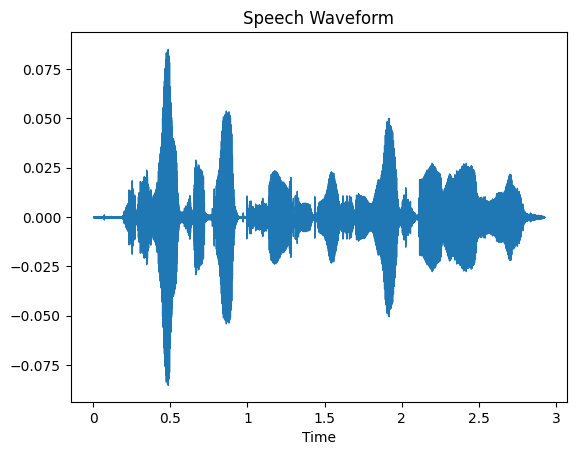

In [38]:
import librosa
import matplotlib.pyplot as plt

filename = "LDC93S1.wav"
data, sample_rate = librosa.load(filename, sr=16000)

# Plot the waveform
plt.figure()
librosa.display.waveshow(data, sr=sample_rate)
plt.title("Speech Waveform")
plt.show()

In [39]:
sample_rate

16000

Per andare a mostrare wideband o narrow band dobbiamo selezionare il numero di campioni da tenere in considerazione per la dimensione della finestra (su cui andare a calcolare la sftf).
- partiamo dalla fs
- il pitch è a 100 Hz
- fisso una dimensione della finestra a 30ms per esempio 
- definisco anche una window_step
Dal momento che abbiamo queste informazioni, conoscendo la dimensione della finestra e la frequenza di campionamento posso determinare quanti campioni ci saranno per ogni finestra

In [40]:
t_window = 0.025
fs = sample_rate
N_window = t_window * sample_rate
print(N_window)

400.0


Avendo una frequenza di campionamento di sr=16Khz, una dimensione della finestra da 101 campioni equivale a:
n_fft / sr * 1000 = dimensione finestra in ms

In [41]:
import numpy as np
from scipy import signal

def stft(data, window_size, hop_length, w_function = 'hann'):
    if w_function == 'hamm':
        windowing = signal.windows.hamming(window_size)
    if w_function == 'rect':
        windowing = signal.windows.boxcar(window_size)
    if w_function== 'hann':
        windowing = signal.windows.hann(window_size)
    n_frames = 1 + (len(data) - window_size) // hop_length
    stft_matrix = np.empty((window_size // 2 + 1, n_frames), dtype=complex)

    for i in range(n_frames):
        frame = data[i * hop_length: i * hop_length + window_size]
        windowed_frame = frame * windowing # applico la hamming window
        stft_matrix[:, i] = np.fft.rfft(windowed_frame)

    return stft_matrix

# window_size = 1024
# hop_length = 512
window_size = int(N_window)
hop_length = int(window_size // 2) + 1
stft_matrix = stft(data, window_size, hop_length)

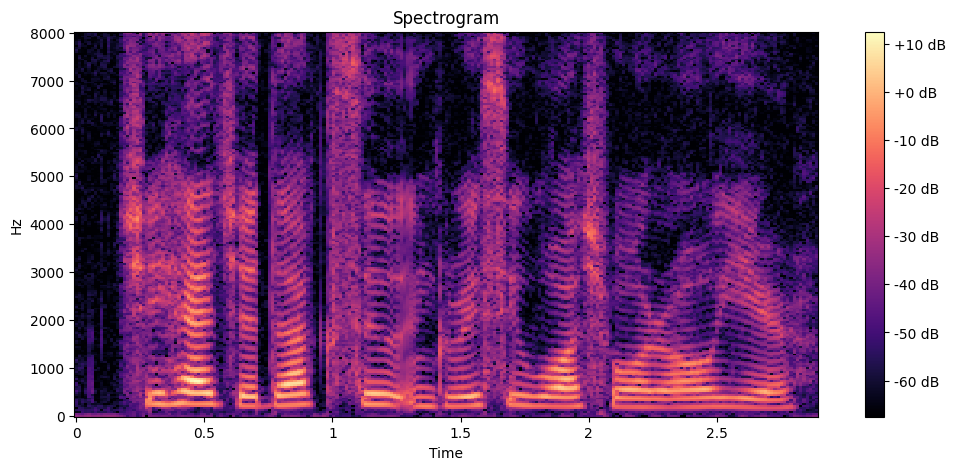

In [42]:
def plot_spectrogram(stft_matrix, sample_rate, hop_length):
    magnitude_spectrogram = np.abs(stft_matrix)
    log_spectrogram = librosa.amplitude_to_db(magnitude_spectrogram)
    plt.figure(figsize=(12, 5))
    librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length, x_axis="time", y_axis="linear")
    plt.colorbar(format="%+2.0f dB")
    plt.title("Spectrogram")
    plt.show()

plot_spectrogram(stft_matrix, sample_rate, hop_length)

Invece, usano finestre più corte abbiamo un Narrow band

In [50]:
t_window = 0.005
fs = sample_rate
N_window = t_window * sample_rate
print(N_window)

80.0


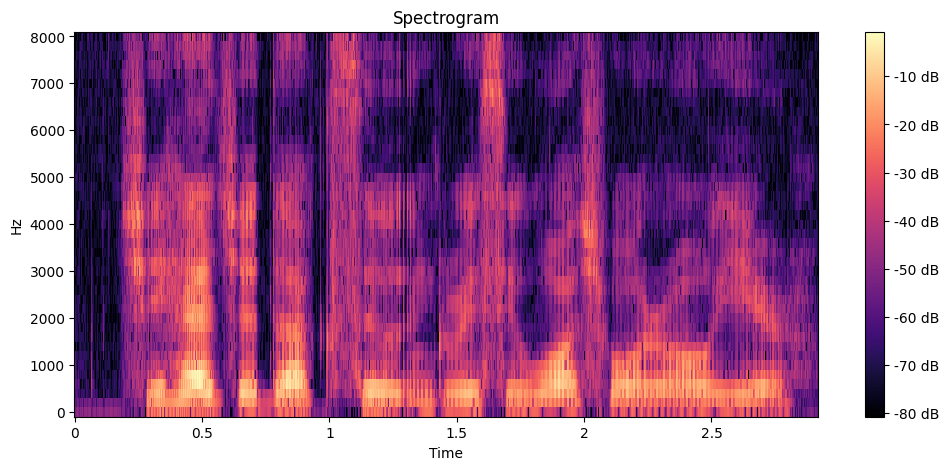

In [51]:
window_size = int(N_window)
hop_length = int(window_size // 2) + 1 # hop del 50%
stft_matrix = stft(data, window_size, hop_length, w_function='hann')
plot_spectrogram(stft_matrix, sample_rate, hop_length)

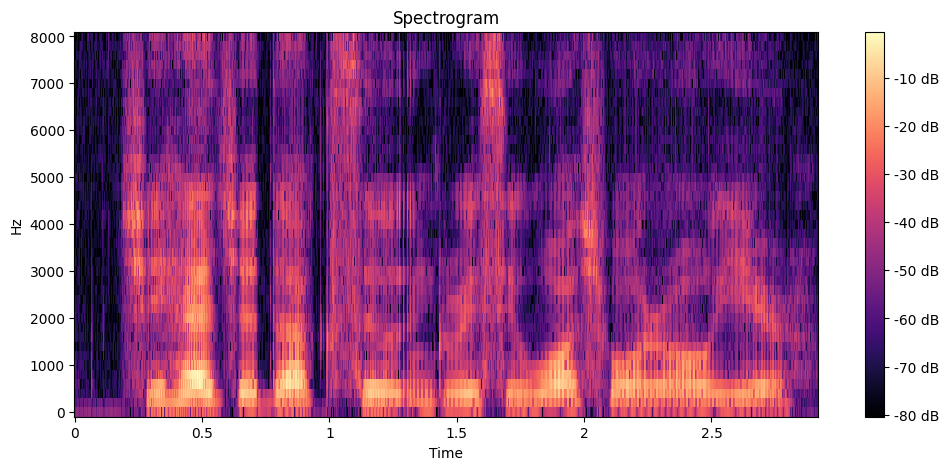

In [52]:
window_size = int(N_window)
hop_length = int(window_size // 2) + 1 # hop del 50%
stft_matrix = stft(data, window_size, hop_length, w_function='hamm')
plot_spectrogram(stft_matrix, sample_rate, hop_length)

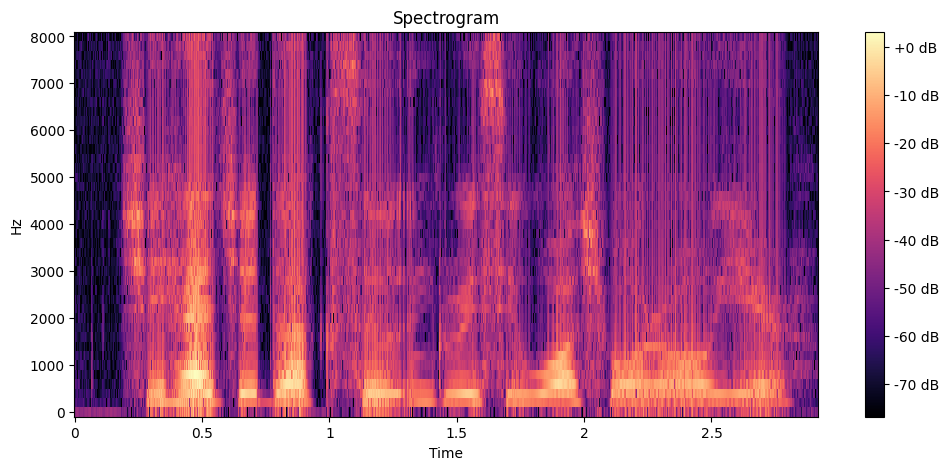

In [53]:
window_size = int(N_window)
hop_length = int(window_size // 2) + 1 # hop del 50%
stft_matrix = stft(data, window_size, hop_length, w_function='rect')
plot_spectrogram(stft_matrix, sample_rate, hop_length)

# Overlap-Add Algorithm
Implementare l'algoritmo di Overlap-add della forma d'onda test.wav usando i seguenti parametri:
- una dimensione della finestra ddi 30ms
- uno step di 15ms
- Funzione half-sin
Plottare la forma d'onda originale e quella ricostruita e mostrare il grafico della ricostruzione dell'errore

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal

In [56]:
# read from storage
filename = 'test.wav'
fs, data = wavfile.read(filename)
data = np.float64(data) # lettura del file
print(data.shape)
print(fs)

(192895,)
44100


Adesso definiamo la dimensione della finestra e dello step. Il numero di campioni della finestra è pari a T*N

In [64]:
window_length_ms = 30
window_step_ms = 15

window_step = int(np.round(fs*window_step_ms / 1000)) # N = fs * t
window_length = int(np.round(fs*window_length_ms / 1000))
window_count = int(np.floor((data.shape[0]-window_length)/window_step)+1)
# il numero di finestre è dato da: (numero totale di campioni - dimensione della finestra) / (passo)

print("Numero di campioni per ogni finestra e step ", window_step)
print("Ogni finestra ha dimensione: ", window_length)
print("Numero di finestre: ", window_count)

Numero di campioni per ogni finestra e step  662
Ogni finestra ha dimensione:  1323
Numero di finestre:  290


Il prossimo step è la windowing function. Consideriamo la hal sine function

In [61]:
windowing_fn = np.sin(np.pi * np.linspace(0.5, window_length - 0.5, window_length)/ window_length) # funzione half sine
n = np.linspace(0.5, window_length-0.5, window_length)

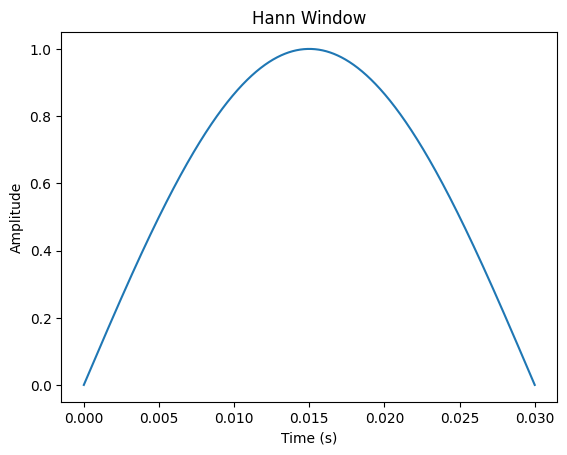

In [62]:
# la funzione di windowing
plt.plot(n/fs, windowing_fn)
plt.title("Hann Window")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

In [68]:
# extract window, ricordando che sono con il passo stabilito
window_matrix = np.zeros([window_length, window_count], dtype=np.float64)
for window_ix in range(window_count):
    window_matrix[:, window_ix] = np.multiply(windowing_fn, data[window_ix*window_step+np.arange(window_length)])
    # nell'indexing mi sposto negli indici che mi interessano. Window_length mi rappresenta il numero di campioni che mi interessa
    # prendere, mentre con window_ix e window_step mi sposto avanti di step in step
print(window_matrix.shape)

(1323, 290)


In [69]:
# ricostruzione del segnale
data_recostructed = np.zeros_like(data)
for window_ix in range(window_count):
    data_recostructed[window_ix*window_step + np.arange(window_length)] += window_matrix[:,window_ix]*windowing_fn
    # qui faccio la stessa cosa, considerando però che per ricostruire i singoli step devo prendere
    # le finestre per intere in widow_ix e riapplicare la funzione di windowing
print(data_recostructed.shape)

(192895,)


In [ ]:
t = np.arange(0, np.float64(data.shape[0])/fs, 1./fs) # genero il tempo andando da inizio a fine, considerando che data
# ha la dimensione di numero di campioni e t = N / fs

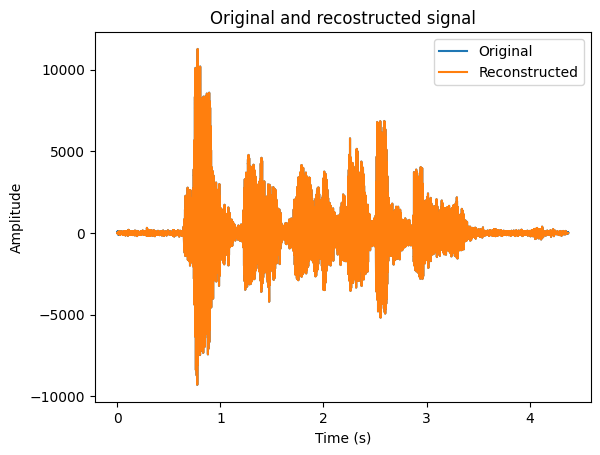

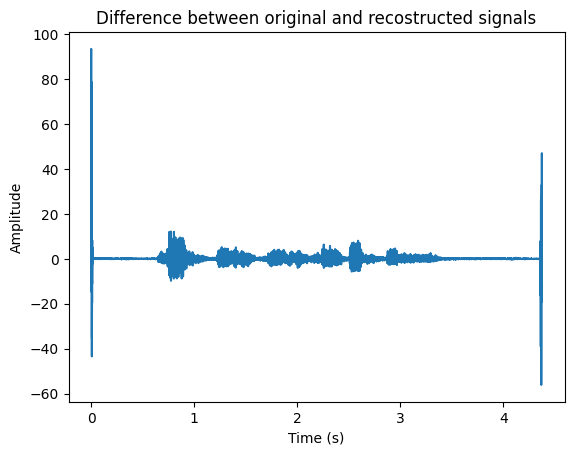

In [72]:
plt.plot(t, data, label="Original")
plt.plot(t, data_recostructed, label="Reconstructed")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.title("Original and recostructed signal")
plt.show()

plt.plot(t, data-data_recostructed)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Difference between original and recostructed signals")
plt.show()

Vogliamo generare il log spectrum della DFT per una finestra di 30ms della forma d'onda test.wav, usiamo la hann window

In [73]:
window_pos = np.random.randint(int((len(data)-window_length)))
print("Posizione: ", window_pos)

datawin = data[window_pos:(window_pos+window_length)]
datawin = datawin / np.max(np.abs(datawin))

spectrum = scipy.fft.rfft(datawin*windowing_fn) # calcolo la DFT
f = np.linspace(0., fs/2, len(spectrum))

Posizione:  152993


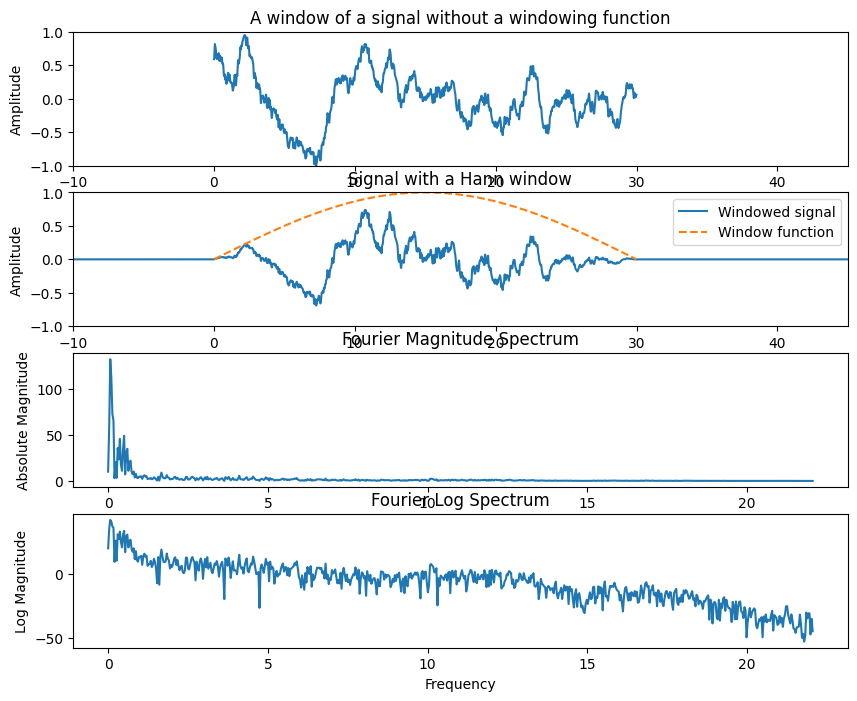

In [76]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(4,1,1)
ax1.plot(n*1000/fs, datawin)
ax1.set_xlabel("Time")
ax1.set_ylabel("Amplitude")
ax1.set_title("A window of a signal without a windowing function")
ax1.axis([-10, 45, -1, 1])

nx = np.concatenate(([-1000,0], n, [window_length, window_length+1000]))
datax = np.concatenate(([0,0], datawin*windowing_fn, [0,0]))
ax2 = fig.add_subplot(4,1,2)
ax2.plot(nx*1000/fs, datax, label="Windowed signal")
ax2.plot(n*1000/fs, windowing_fn, '--', label="Window function")
ax2.legend()
ax2.set_xlabel("Time")
ax2.set_ylabel("Amplitude")
ax2.set_title("Signal with a Hann window")
ax2.axis([-10, 45, -1, 1])

ax3 = fig.add_subplot(4,1,3)
ax3.plot(f/1000, np.abs(spectrum))
ax3.set_xlabel("Frequency")
ax3.set_ylabel("Absolute Magnitude")
ax3.set_title("Fourier Magnitude Spectrum")

ax4 = fig.add_subplot(4,1,4)
ax4.plot(f/1000, 20*np.log10(np.abs(spectrum)))
ax4.set_xlabel("Frequency")
ax4.set_ylabel("Log Magnitude")
ax4.set_title("Fourier Log Spectrum")
plt.show()

# Considerazioni finali
Il windowing con overlap-add è la base e comunemente usato nello speech proecessing. Permette di modificare sezioni del segnale che non causano discontinuità del segnale. 

L'unico svantaggio notabile dell'overlapping è che l'overlap causa ridondanza, dal momento che l'infomazione si ripete tra le finestre k e k+1. 

Il processo di overlap and add può essere modificato per rimuovere la ridondanza proiettando l'area di sovrapposizione tra due spazi ortogonali. Questo metodo è conosciuto come lapped transforms e sono tuttavia al di fuori della normale trasformata.

Nel coding della applicazioni, le trasformate lapped sono preferite